# Building a Neural Network with R (from Scratch)
Source - Article: http://selbydavid.com/2018/01/09/neural-network/  
Source - GitHub: https://github.com/Selbosh/selbosh.github.io/blob/source/content/post/2018-01-09-neural-network.Rmd

In [1]:
two_spirals <- function(N = 200,
                        radians = 3*pi,
                        theta0 = pi/2,
                        labels = 0:1) {
    N1 <- floor(N / 2)
    N2 <- N - N1
    
    theta <- theta0 + runif(N1) * radians
    spiral1 <- cbind(-theta * cos(theta) + runif(N1),
                     theta * sin(theta) + runif(N1))
    spiral2 <- cbind(theta * cos(theta) + runif(N2),
                     -theta * sin(theta) + runif(N2))
    
    points <- rbind(spiral1, spiral2)
    classes <- c(rep(0, N1), rep(1, N2))
    
    data.frame(x1 = points[, 1],
               x2 = points[, 2],
               class = factor(classes, labels = labels))
}

set.seed(42)
hotdogs <- two_spirals(labels = c('not hot dog', 'hot dog'))

In [2]:
head(hotdogs)
unique(hotdogs$class)

x1,x2,class
7.9588024,-6.1946790,not hot dog
6.0310557,-8.1090756,not hot dog
2.0527836,-3.0004321,not hot dog
9.7830504,0.6983522,not hot dog
-0.8306828,7.5677887,not hot dog
-5.3961604,1.5992630,not hot dog


[1] not hot dog hot dog    
Levels: not hot dog hot dog

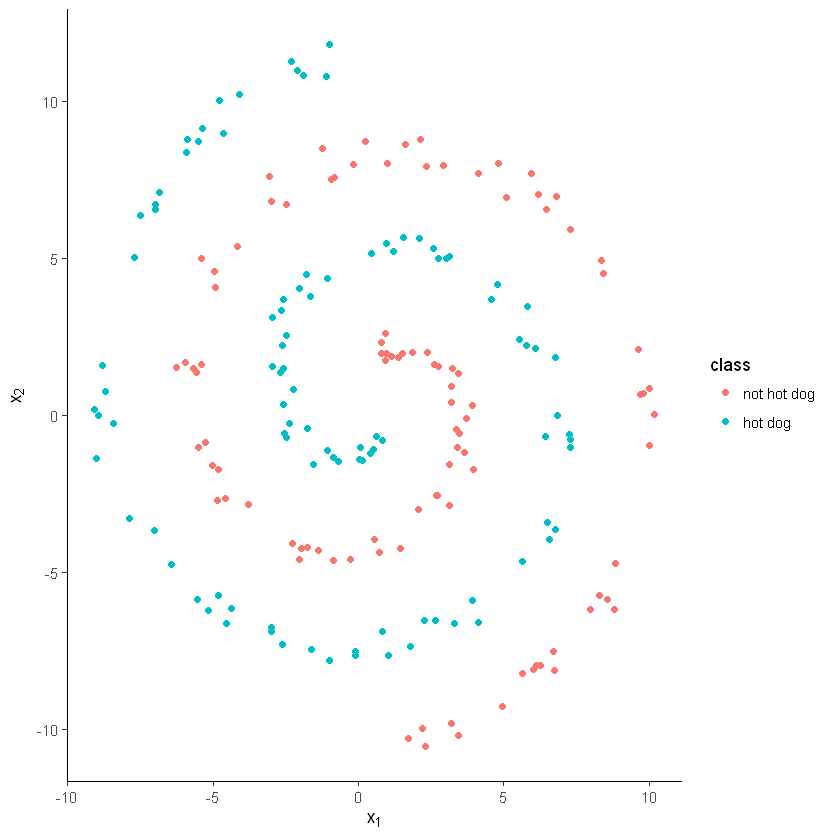

In [8]:
library(ggplot2)

theme_set(theme_classic())
ggplot(hotdogs) +
    aes(x1, x2, colour = class) +
    geom_point() +
    labs(x = expression(x[1]),
         y = expression(x[2]))

In [16]:
logreg <- glm(class ~ x1 + x2, family = binomial, data = hotdogs)
correct <- sum((fitted(logreg) > .5) + 1 == as.integer(hotdogs$class))

correct / nrow(hotdogs) * 100 # % correct with a logistic regression

[1] 67

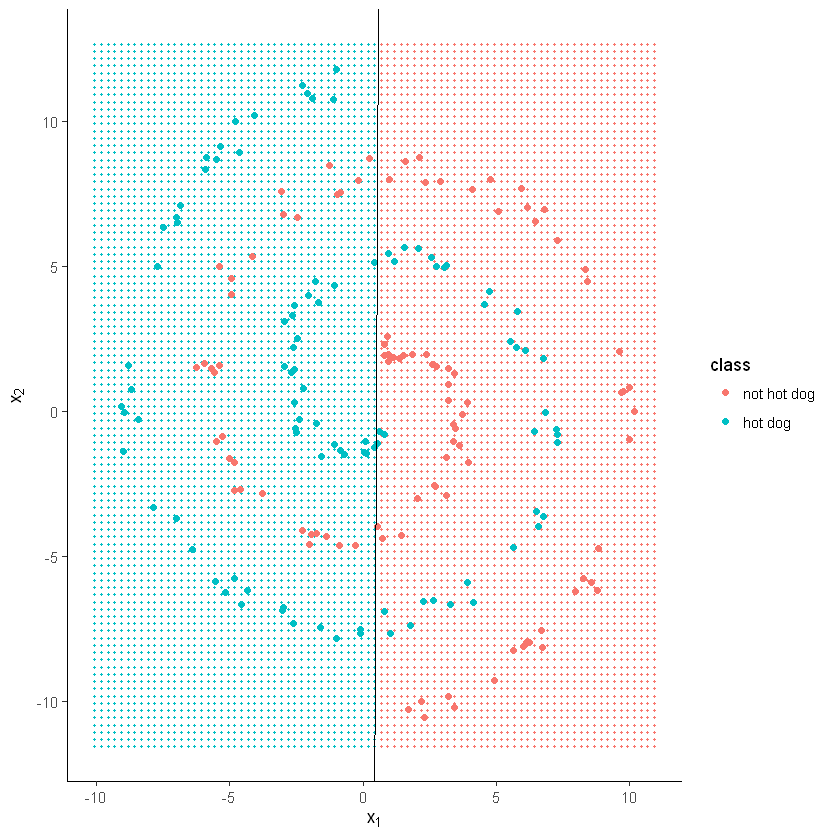

In [17]:
beta <- coef(logreg)
grid <- expand.grid(x1 = seq(min(hotdogs$x1) - 1,
                             max(hotdogs$x1) + 1,
                             by = .25),
                    x2 = seq(min(hotdogs$x2) - 1,
                             max(hotdogs$x2) + 1,
                             by = .25))
grid$class <- factor((predict(logreg, newdata = grid) > 0) * 1,
                     labels = c('not hot dog', 'hot dog'))

ggplot(hotdogs) + aes(x1, x2, colour = class) +
  geom_point(data = grid, size = .5) +
  geom_point() +
  labs(x = expression(x[1]), y = expression(x[2])) +
  geom_abline(intercept = -beta[1]/beta[3],
              slope = -beta[2]/beta[3])

In [19]:
sigmoid <- function(x) 1 / (1 + exp(-x))

feedforward <- function(x, w1, w2) {
  z1 <- cbind(1, x) %*% w1
  h <- sigmoid(z1)
  z2 <- cbind(1, h) %*% w2
  list(output = sigmoid(z2), h = h)
}
    
backpropagate <- function(x, y, y_hat, w1, w2, h, learn_rate) {
  dw2 <- t(cbind(1, h)) %*% (y_hat - y)
  dh  <- (y_hat - y) %*% t(w2[-1, , drop = FALSE])
  dw1 <- t(cbind(1, x)) %*% (h * (1 - h) * dh)
  
  w1 <- w1 - learn_rate * dw1
  w2 <- w2 - learn_rate * dw2
  
  list(w1 = w1, w2 = w2)
}
    
train <- function(x, y, hidden = 5, learn_rate = 1e-2, iterations = 1e4) {
  d <- ncol(x) + 1
  w1 <- matrix(rnorm(d * hidden), d, hidden)
  w2 <- as.matrix(rnorm(hidden + 1))
  for (i in 1:iterations) {
    ff <- feedforward(x, w1, w2)
    bp <- backpropagate(x, y,
                        y_hat = ff$output,
                        w1, w2,
                        h = ff$h,
                        learn_rate = learn_rate)
    w1 <- bp$w1; w2 <- bp$w2
  }
  list(output = ff$output, w1 = w1, w2 = w2)
}
    

In [20]:
x <- data.matrix(hotdogs[, c('x1', 'x2')])
y <- hotdogs$class == 'hot dog'
nnet5 <- train(x, y, hidden = 5, iterations = 1e5)

In [21]:
mean((nnet5$output > .5) == y)

[1] 0.735

In [22]:
ff_grid <- feedforward(x = data.matrix(grid[, c('x1', 'x2')]),
                       w1 = nnet5$w1,
                       w2 = nnet5$w2)
grid$class <- factor((ff_grid$output > .5) * 1,
                     labels = levels(hotdogs$class))

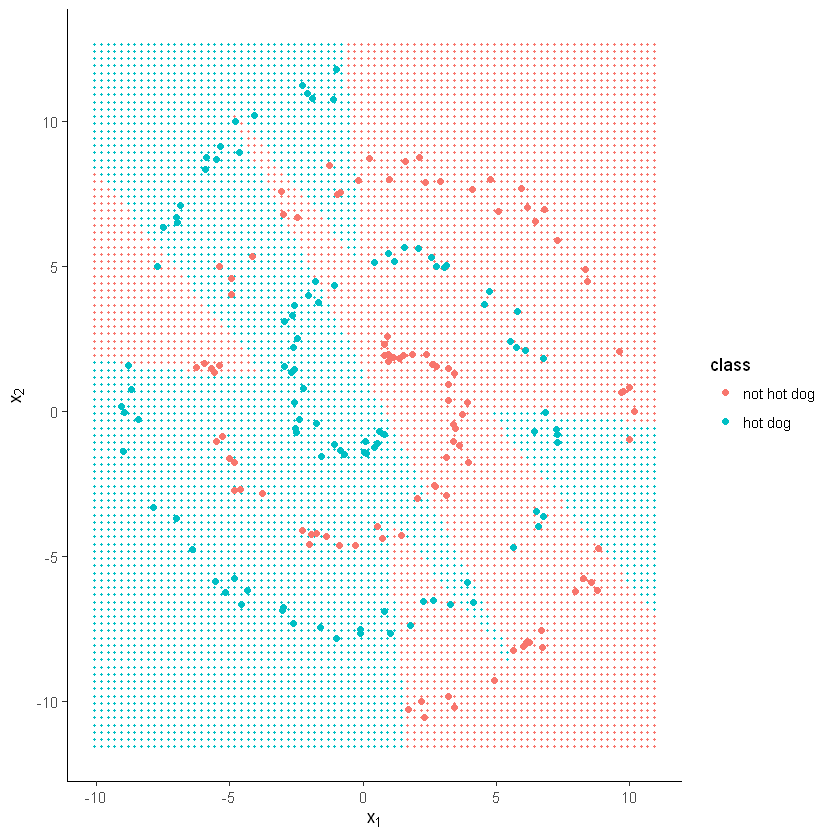

In [23]:
ggplot(hotdogs) + aes(x1, x2, colour = class) +
  geom_point(data = grid, size = .5) +
  geom_point() +
  labs(x = expression(x[1]), y = expression(x[2]))

In [24]:
# how about 30 nodes:
nnet30 <- train(x, y, hidden = 30, iterations = 1e5)

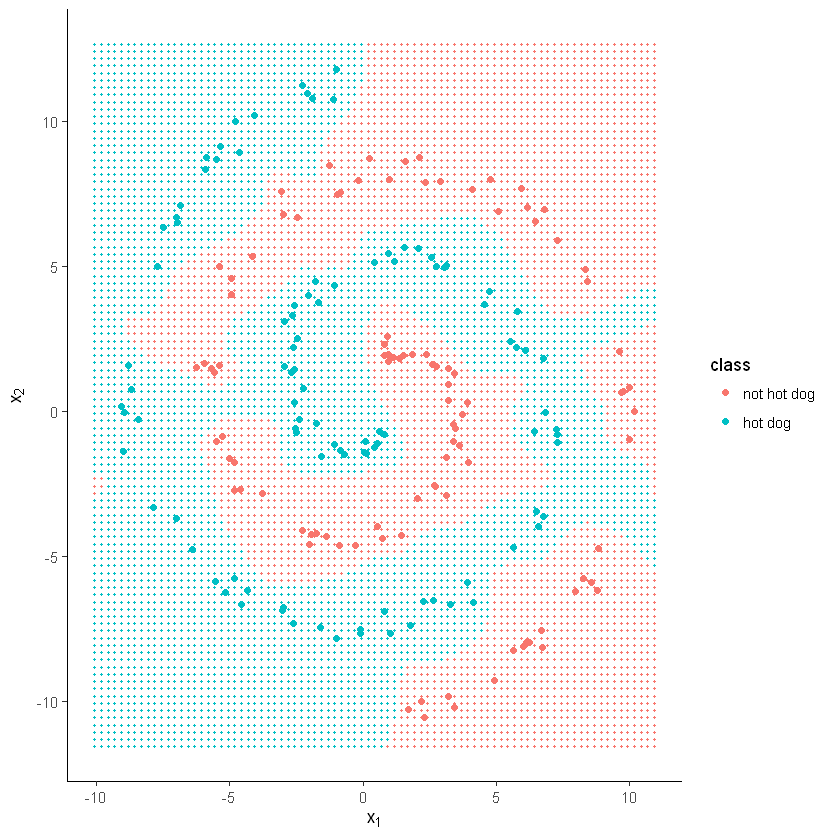

In [25]:
ff_grid <- feedforward(x = data.matrix(grid[, c('x1', 'x2')]),
                       w1 = nnet30$w1,
                       w2 = nnet30$w2)
grid$class <- factor((ff_grid$output > .5) * 1,
                     labels = levels(hotdogs$class))

ggplot(hotdogs) + aes(x1, x2, colour = class) +
  geom_point(data = grid, size = .5) +
  geom_point() +
  labs(x = expression(x[1]), y = expression(x[2]))

In [27]:
# and one hidden layer?
nnet1 <- train(x, y, hidden = 1, iterations = 1e5)

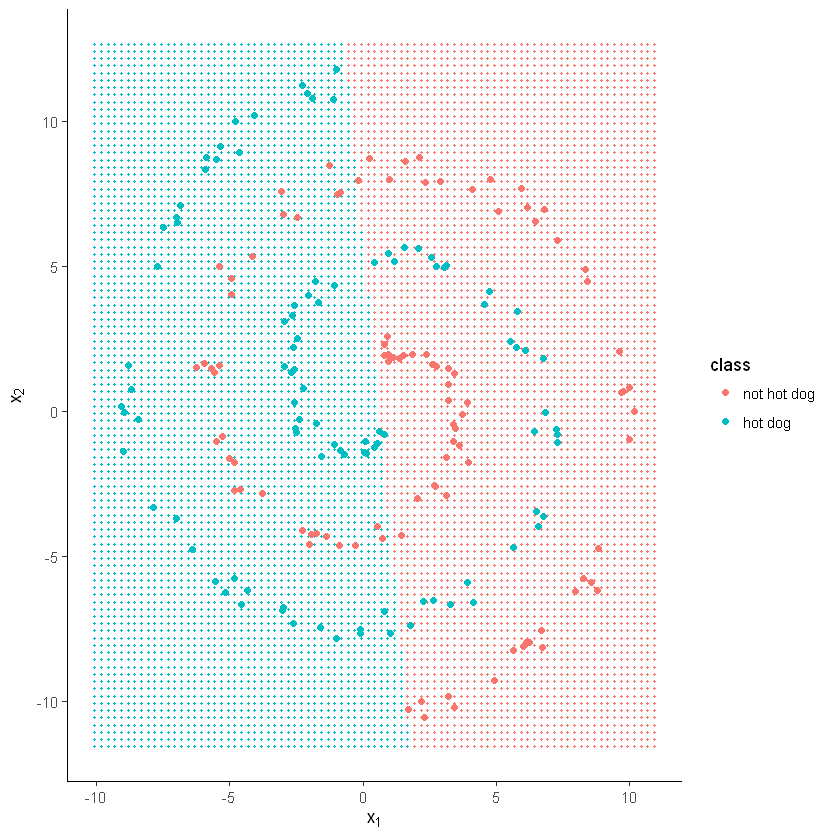

In [28]:
ff_grid <- feedforward(x = data.matrix(grid[, c('x1', 'x2')]),
                       w1 = nnet1$w1,
                       w2 = nnet1$w2)
grid$class <- factor((ff_grid$output > .5) * 1,
                     labels = levels(hotdogs$class))

ggplot(hotdogs) + aes(x1, x2, colour = class) +
  geom_point(data = grid, size = .5) +
  geom_point() +
  labs(x = expression(x[1]), y = expression(x[2]))

# R6 Class Implementation

In [29]:
library(R6)
NeuralNetwork <- R6Class("NeuralNetwork",
  public = list(
    X = NULL,  Y = NULL,
    W1 = NULL, W2 = NULL,
    output = NULL,
    initialize = function(formula, hidden, data = list()) {
      # Model and training data
      mod <- model.frame(formula, data = data)
      self$X <- model.matrix(attr(mod, 'terms'), data = mod)
      self$Y <- model.response(mod)
      
      # Dimensions
      D <- ncol(self$X) # input dimensions (+ bias)
      K <- length(unique(self$Y)) # number of classes
      H <- hidden # number of hidden nodes (- bias)
      
      # Initial weights and bias
      self$W1 <- .01 * matrix(rnorm(D * H), D, H)
      self$W2 <- .01 * matrix(rnorm((H + 1) * K), H + 1, K)
    },
    fit = function(data = self$X) {
      h <- self$sigmoid(data %*% self$W1)
      score <- cbind(1, h) %*% self$W2
      return(self$softmax(score))
    },
    feedforward = function(data = self$X) {
      self$output <- self$fit(data)
      invisible(self)
    },
    backpropagate = function(lr = 1e-2) {
      h <- self$sigmoid(self$X %*% self$W1)
      Yid <- match(self$Y, sort(unique(self$Y)))
      
      haty_y <- self$output - (col(self$output) == Yid) # E[y] - y
      dW2 <- t(cbind(1, h)) %*% haty_y
      
      dh <- haty_y %*% t(self$W2[-1, , drop = FALSE])
      dW1 <- t(self$X) %*% (self$dsigmoid(h) * dh)
      
      self$W1 <- self$W1 - lr * dW1
      self$W2 <- self$W2 - lr * dW2
      
      invisible(self)
    },
    predict = function(data = self$X) {
      probs <- self$fit(data)
      preds <- apply(probs, 1, which.max)
      levels(self$Y)[preds]
    },
    compute_loss = function(probs = self$output) {
      Yid <- match(self$Y, sort(unique(self$Y)))
      correct_logprobs <- -log(probs[cbind(seq_along(Yid), Yid)])
      sum(correct_logprobs)
    },
    train = function(iterations = 1e4,
                     learn_rate = 1e-2,
                     tolerance = .01,
                     trace = 100) {
      for (i in seq_len(iterations)) {
        self$feedforward()$backpropagate(learn_rate)
        if (trace > 0 && i %% trace == 0)
          message('Iteration ', i, '\tLoss ', self$compute_loss(),
                  '\tAccuracy ', self$accuracy())
        if (self$compute_loss() < tolerance) break
      }
      invisible(self)
    },
    accuracy = function() {
      predictions <- apply(self$output, 1, which.max)
      predictions <- levels(self$Y)[predictions]
      mean(predictions == self$Y)
    },
    sigmoid = function(x) 1 / (1 + exp(-x)),
    dsigmoid = function(x) x * (1 - x),
    softmax = function(x) exp(x) / rowSums(exp(x))
  )
)

In [30]:
irisnet <- NeuralNetwork$new(Species ~ ., data = iris, hidden = 5)

In [31]:
irisnet$train(9999, trace = 1e3, learn_rate = .0001)

Iteration 1000	Loss 151.038813105831	Accuracy 0.68
Iteration 2000	Loss 82.6551808915209	Accuracy 0.84
Iteration 3000	Loss 65.6912647656911	Accuracy 0.966666666666667
Iteration 4000	Loss 52.2470394194697	Accuracy 0.973333333333333
Iteration 5000	Loss 41.029889648112	Accuracy 0.973333333333333
Iteration 6000	Loss 32.9038616561112	Accuracy 0.973333333333333
Iteration 7000	Loss 27.3152426546737	Accuracy 0.98
Iteration 8000	Loss 23.4423065896135	Accuracy 0.98
Iteration 9000	Loss 20.6768579148378	Accuracy 0.98


In [32]:
irisnet

<NeuralNetwork>
  Public:
    accuracy: function () 
    backpropagate: function (lr = 0.01) 
    clone: function (deep = FALSE) 
    compute_loss: function (probs = self$output) 
    dsigmoid: function (x) 
    feedforward: function (data = self$X) 
    fit: function (data = self$X) 
    initialize: function (formula, hidden, data = list()) 
    output: 0.970399801326407 0.964485258285899 0.967832502555438 0. ...
    predict: function (data = self$X) 
    sigmoid: function (x) 
    softmax: function (x) 
    train: function (iterations = 10000, learn_rate = 0.01, tolerance = 0.01, 
    W1: -0.234619777684743 -0.371121286592842 -1.21203133026818  ...
    W2: -0.343559664423871 -3.5325389352613 2.32228067771692 1.1 ...
    X: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1  ...
    Y: setosa setosa setosa setosa setosa setosa setosa setosa  ...

In [34]:
# simple prediction line with R6 class:  irisnet$train(1000)$predict(newdata)